In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open('/content/drive/MyDrive/names.txt','r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i, s in enumerate(chars)}
s2i['.'] = 0
i2s = {i:s for s, i in s2i.items()}

In [4]:
# hyperparameters
BLOCK_SIZE = 3
EMBEDDING_SIZE = 10
NUM_NEURONS = 200
VOCAB_SIZE = len(i2s)

In [5]:
# @title ######Generate Dataset
def generate_dataset(words):
  block_size = BLOCK_SIZE
  x, y = [], []

  # here the setup is like a rolling window. New context is being appended, old ones being removed, so the context moves/slides along
  for w in words:
    #print(w)
    context = [0] * block_size

    for ch in w + '.':
      ix = s2i[ch]
      x.append(context)
      y.append(ix)

      #print(''.join(i2s[i] for i in context), '---->', i2s[ix]) # first 3 characters ----> next character in data
      context = context[1:] + [ix] # crop and append

  #print(x)
  x = torch.tensor(x)
  y = torch.tensor(y)
  return x, y

In [6]:
# @title ######Split Dataset
def split_dataset(words):
  random.seed(42)
  random.shuffle(words)
  n1 = int(0.8*len(words))
  n2 = int(0.9*len(words))

  X_train, Y_train = generate_dataset(words[:n1])
  X_dev, Y_dev = generate_dataset(words[n1:n2])
  X_test, Y_test = generate_dataset(words[n2:])

  return X_train, Y_train, X_dev, Y_dev, X_test, Y_test

In [ ]:
X_train, Y_train, X_dev, Y_dev, X_test, Y_test = split_dataset(words)

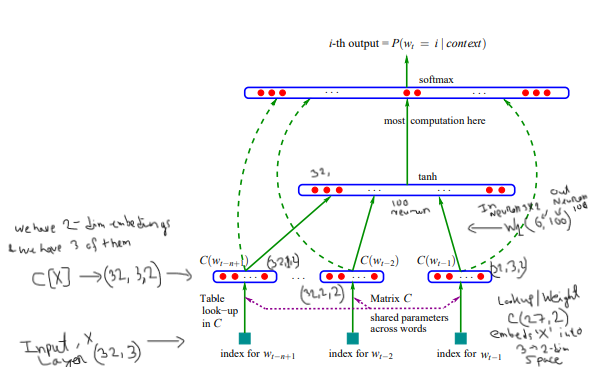

tensor(-0.0009) tensor(1.0075)
tensor(-0.0072) tensor(15.9919)


10000

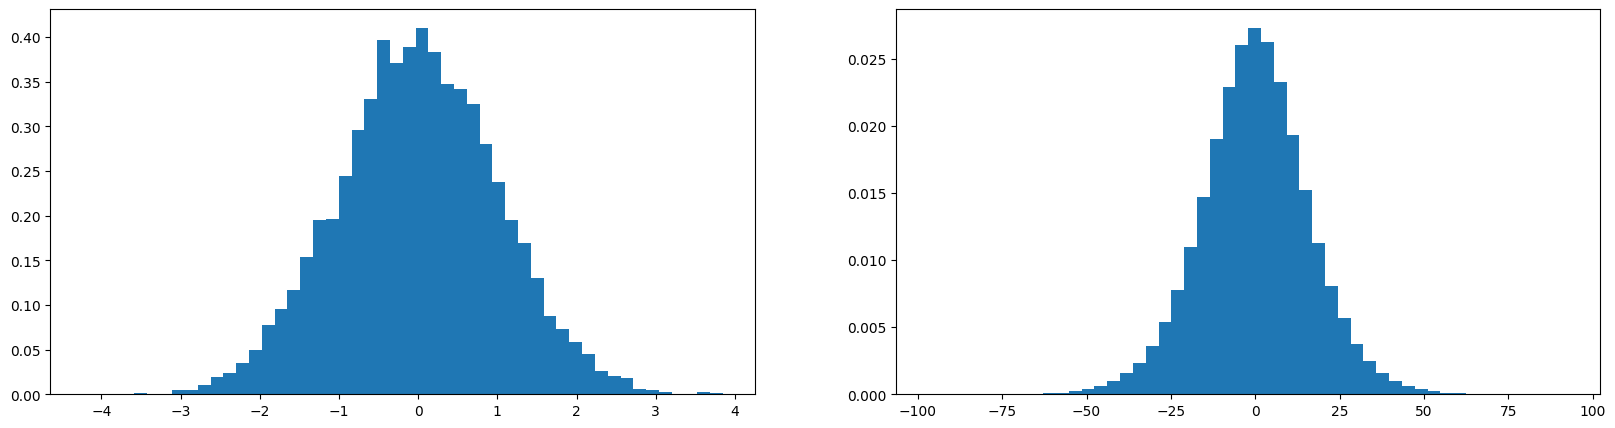

In [ ]:
# example of effect on gaussian distribution
p = torch.randn(1000,10)
w = torch.randn(10,1000) * 5
#w = torch.randn(10,1000) / 10**0.5
q = p @ w
print(p.mean(), p.std())
print(q.mean(), q.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(p.view(-1).tolist(),50, density=True) # frequency(density) vs class value
plt.subplot(122)
plt.hist(q.view(-1).tolist(),50, density=True) # frequency(density) vs class value
len(p.view(-1).tolist())

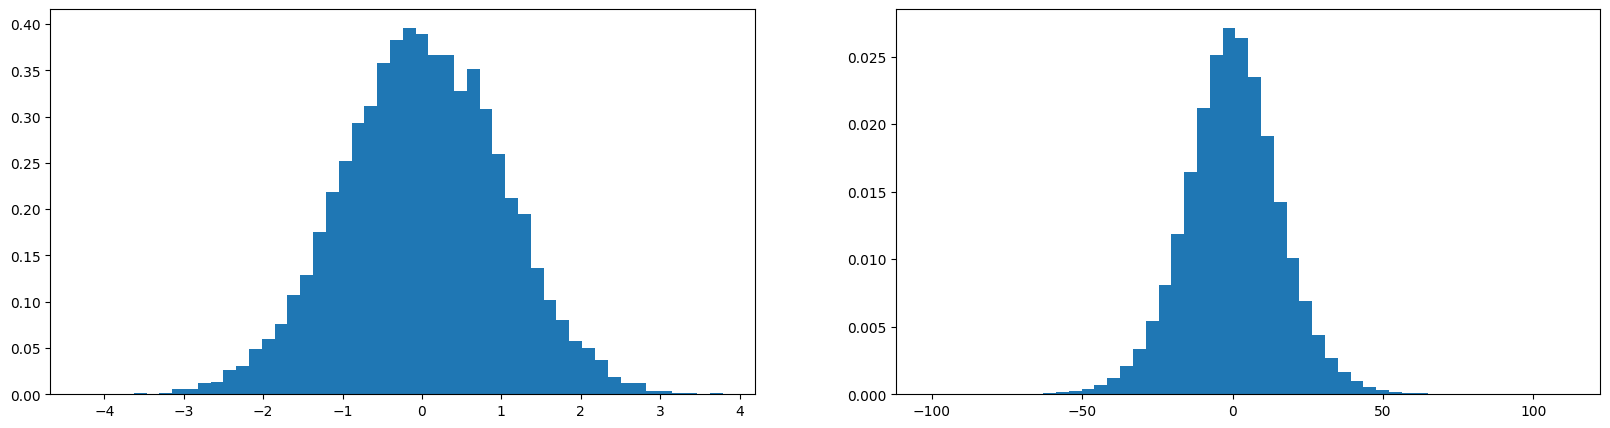


**Kaiming Init:** But how to initialize the weights and biases so that the Non-linear functions (tanh, sigmoid etc) doesn't kill the gradients? Do we keep testing different scaling values manually and hope it works? NO !! </br>
A 2015 paper by Kaiming explored this problem and came up with the solution. So basically Non-linear or 'Squashing' Functions take inputs and squeezes them into a fixed range. For 'tanh' very high values are squashed to -1 or 1. For ReLU all -ve values gets discarded. These cause a loss in data, and a decrease/deterioration of the passing data. </br>
*This can be overcome by initializiting the weights and biases with a 'gain' value which basically boosts the W,b's, so that the squashing effect will be less impactful* </br>
When we initialize weights with values from normal distribution, we can see the gaussian distribution nature of it if we plot a histogram.
But when y = x @ w + b occurs, this scales the values and the gaussian distribution gets more spread out (distributed over a wider range). BUT WE WANT TO PRESEARVE THE ORIGINAL GAUSSIAN AS MUCH AS POSSIBLE. </br>
```
p = torch.randn(1000,10) # mean-tensor(0.0058) std-tensor(1.0093)
# w = torch.randn(10,1000) * 5 # mean-tensor(0.0182) std-tensor(15.6765)
# w = torch.randn(10,1000) * 0.2 # mean-tensor(0.0013) std-tensor(0.6245)
w = torch.randn(10,1000) / 10**0.5 # mean-tensor(-0.0011) std-(1.0123)
q = p @ w
plt.hist(p.view(-1).tolist(),50, density=True)
plt.hist(q.view(-1).tolist(),50, density=True)

# q = p @ w is a linear layer; with gain=1, std=gain/sqrt(fan_in)
# tanh(q) is non-linear layer with gain=5/3, std=gain/sqrt(fan_in)
# we will basically do weights * std for every type of layers.
```
mean-tensor(0.0122) std-tensor(0.9911) for p </br>
mean-tensor(0.0182) std-tensor(15.6765) for q when w x5</br>
mean-tensor(0.0013) std-tensor(0.6245) for q when w x0.2</br>
mean-tensor(0.0002) std-tensor(1.0047) for q when w/ 10^0.5</br>
We can see from the histograms when 'w' is multiplied by 5, the gaussian for   q = p @ w spreads out more and has larger than 1. For w x 0.2, std is smaller than 1. But gaussian dist. has std of 1 (1.0093). We see from the case where   w x 10^0.5 the std is near '1' which is what we want. </br>
Kaiming has found this value and calls it a 'gain' which compensates for the squashing. For ReLU it is std = gain/ sqrt(2/fan_in), gain = sqrt(2); where fan_in is the number of inputs this weight layer has. </br>
So in our case --> w = torch.randn(10,1000) / 10**0.5 || inputs to this weight layer is '10'=fan_in; so w x sqrt(2/10) is how we need to initialize this weight layer. And this will help that weight layer to compensate for the operations performed on that layer and keep a gaussian distribution. </br>

We understood that initiazation is very important in training the NN effectively and saw Kaiming initialization. But modern advancements have made this initialization less important. Techniques like batch normalization, residual connection, rmsprop, adam etc </br>

torch implementation--> torch.nn.init.kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')

In [ ]:
# @title ######Initialize parameters
g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((VOCAB_SIZE, EMBEDDING_SIZE),              generator=g)
W1 = torch.randn((EMBEDDING_SIZE*BLOCK_SIZE, NUM_NEURONS),  generator=g) * ((5/3)/(EMBEDDING_SIZE*BLOCK_SIZE)**0.5)  # to fix saturated tanh; this will pull down all the 'hpreact' values so 'h' will not be saturated in -1, 1 region
b1 = torch.randn(NUM_NEURONS,                               generator=g) * 0.01 # to fix saturated tanh; also multiplied by 0.01 not 0 to keep some entropy, it helps
W2 = torch.randn((NUM_NEURONS, VOCAB_SIZE),                 generator=g) * 0.01 # to fix initialization. Also din't multiply by 0.0 to break symmetry because if all weights are zeros then results might come out symmetric at first
b2 = torch.randn(VOCAB_SIZE,                                generator=g) * 0.0  # to fix the initialization problem. since addition no problem with symmetry breaking

bngain = torch.ones((1, NUM_NEURONS))
bnbias = torch.zeros((1, NUM_NEURONS))

bnmean_running = torch.zeros((1, NUM_NEURONS)) # initialize 0 mean
bnstd_running = torch.ones((1, NUM_NEURONS)) # initialize 1 std

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12297


# Batch Normalization
We want the layers to have a gaussian distribution (mean=0, std=1) atleast at initialization and did Kaiming init to do so. But Batch normalization says, if you have a layer whose distribution you want to be gaussian, then why not take that layer and normalize it to be gaussian. </br>
Usual Nomalization equation = (Value - mean_value)/std </br>
But we don't want to normalize the layer every single iteration. We want at initialization layers to have  roughly gaussian dist. since at init everything should have equal probability of happening.</br>
But as the NN learns we want the distribution to scale, shift, move around i.e. learn. We want some neurons to be trigger happy, some to be docile. This will not happen if we force gaussian distribution on the neuron layers everytime</br>
So to do so we introduce a **bngain** and **bnbias** </br>
From 2015 google batch normalization paper </br>

```
# mini batch mean
hpreact.mean(0, keepdim=True).shape
# mini batch std
hpreact.std(0, keepdim=True).shape
 # minibatch normalization
(hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
# scale and shift
bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

```
So at initialization bngain=1, bnbias=0; it allows to fully normalize the hpreact. Thus h=torch.tanh(hpreact) will come out gaussian atleast at init. Then we allow backpropagation to change bngain and bnbias to accomodate the learning capability of the NN. So after training the layers will still end up with distribution different from gaussian, which means NN has learned. </br>

**BUT THERE IS SOMETHING TERRIBLE HAPPENING** We started the NN with single inputs-->hidden layer(tanh)-->logits. After adding mini batch, single inputs became batch of inputs. But inputs/examples were still **INDEPENDENT** of each other. But by batch normalization we have normalized every single input in the minibatch with the minibatch mean. So every input feeding into the hidden states, logits are **NOT INDENPENDENT** of each other anymore; since they were normalized by all the minibatch examples. So its **coupling the layer operations and normalization opertions**  </br> </br>
But this turns out to be a good thing, since it adds some jitter/entropy to the hidden states, logits. Because every input is effected by the data in the minibatch, every minibatch produces different inputs. This has the same effect as **DATA AUGMENTATION** and the entropy introduced by doing this is actually **REGULARIZING** the layers. So its preventing itself **from OVERFITTING**. People don't like batch normaliztion because its coupling layer and normalization operations, but it just works better. </br></br>

**Calibrating bnmean/bnstd after training** We are doing this because the batch normalization now always expects batches of data to be passed through training.
So when we want to deploy the model somewhere, and feed in single inputs for predictions the NN will not work since it wanted batch of inputs
so after training we will set in stone the bnmean & bnstd,
so that these values can be now used always and the NN won't expect batches of data to caluculate mean and std.
But turns out people are lazy to do this extra 2nd step after training. So they came up with the idea of running updates of bnmean/bnstd.


```
  bnmean_running = torch.zeros((1, NUM_NEURONS)) # initialize 0 mean
  bnstd_running = torch.ones((1, NUM_NEURONS)) # initialize 1 std
  # training step
  bnmeani = hpreact - hpreact.mean(0, keepdim=True) # for running update
  bnstdi = hpreact.std(0, keepdim=True) # for running update
  hpreact = bngain * bnmeani / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running  = 0.999 * bnstd_running + 0.001 * bnstdi
```
updating bnmean_running every iteration with 0.001 bnmeani (mean for that iteration). So at the end of training bnmean_running will be calulated over the training set and we don't need the extra step at the end to calculate the bnmean and bnstd over the entire training set. </br>
This bnmean_running/bnstd_running doesn't require gradient tracking so no graphs are created and only algebric calculation are done </br>
And we see bnmean_running/bnstd_running has the same values as bnmean/bnstd calculated at the end. So we effectively combined the two stages</br>
BTW batchnorm doesn't need b1 biases, since it has its own bias bnbias </br>



In [ ]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [ ]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [ ]:
normalized_hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

In [ ]:
# @title #####training
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 # in case of batchnorm this b1 is useless since its getting subtracted in next step(hpreact-bnmeani)
                             # instead batchnorm has its own bnbias. Keeping b1 will not effect anything, its just wasteful since gradient graph(all 0's) is being made for b1
# ------------------------------batch norm ------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True) # for running update
  bnstdi = hpreact.std(0, keepdim=True) # for running update
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # updating bnmean_running every iteration with 0.001 bnmeani (mean for that iteration)
    bnstd_running  = 0.999 * bnstd_running + 0.001 * bnstdi # so at the end of training bnmean_running will be calulated over the training set and we don't need the extra step
# ---------------------------------------------------------------------------------
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.314689
  10000/ 200000: 2.198443
  20000/ 200000: 2.337455
  30000/ 200000: 2.435885
  40000/ 200000: 2.011928
  50000/ 200000: 2.259471
  60000/ 200000: 2.477501
  70000/ 200000: 2.102000
  80000/ 200000: 2.278812
  90000/ 200000: 2.186206
 100000/ 200000: 1.947383
 110000/ 200000: 2.301026
 120000/ 200000: 1.983654
 130000/ 200000: 2.452322
 140000/ 200000: 2.383932
 150000/ 200000: 2.198679
 160000/ 200000: 1.973302
 170000/ 200000: 1.866808
 180000/ 200000: 1.997268
 190000/ 200000: 1.834684


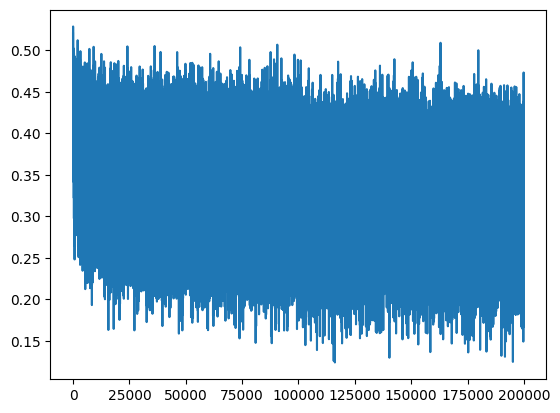

In [ ]:
plt.plot(lossi)

In [ ]:
# @title ######calibrate the batch norm at the end of training for evaluation and deployment
'''
We are doing this because the batch normalization now always expects batches of data to be passed through training.
So when we want to deploy the model somewhere, and feed in single inputs for predictions the NN will not work since it wanted batch of inputs
so after training we will set in stone the bnmean & bnstd,
so that these values can be now used always and the NN won't expect batches of data to caluculate mean and std.
But turns out people are lazy to do this extra 2nd step after training. So they came up with the idea of running updates of bnmean/bnstd.
'''
with torch.no_grad():
  # pass the training set through
  emb = C[X_train]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
bnmean_running

tensor([[-2.3539,  0.6872, -0.9001,  1.0159,  1.0894,  1.0862,  1.7389, -2.1357,
          0.5608,  1.4246, -1.6445, -2.7426, -0.4861, -0.1510, -0.0687, -1.1550,
          0.6891, -2.6399, -0.1283,  1.6240, -0.7732, -0.2865,  0.0467,  0.6119,
          1.1172,  0.2433,  2.0542,  0.5778,  0.8515,  1.7729, -0.3741, -0.8385,
         -0.0831, -0.5198, -0.3817, -1.0698, -0.0781,  0.3370, -0.5769,  0.9935,
         -0.4507, -1.3313, -0.2895, -0.2299,  0.6877,  0.6936,  2.0835, -0.7759,
          2.3804,  1.8613,  0.8118,  0.2735,  1.8802,  0.4705,  0.6656, -1.8962,
         -0.0420,  0.4356,  1.3924, -0.8906, -0.4676,  1.1688,  0.5539,  0.6000,
          1.5853,  1.2103, -1.0171,  2.1421, -0.6330,  0.1071, -0.2926, -0.4831,
          0.9506, -1.0144, -2.9925,  0.6268,  1.4404, -0.1574,  0.0955,  0.5159,
          0.2487,  1.2401,  2.0104,  0.6695,  0.0768, -0.0851, -1.6767,  0.2963,
          2.2374, -0.0100, -0.6669,  1.4356, -0.8431, -1.2317, -1.0220,  0.2201,
          0.1928, -0.3261,  

In [ ]:
bnmean

tensor([[-2.3355,  0.6776, -0.9133,  1.0163,  1.0865,  1.0938,  1.7437, -2.1208,
          0.5730,  1.4455, -1.6343, -2.7372, -0.4752, -0.1412, -0.0745, -1.1722,
          0.6851, -2.6219, -0.1065,  1.6326, -0.7706, -0.3063,  0.0479,  0.6115,
          1.1173,  0.2427,  2.0500,  0.5832,  0.8527,  1.7680, -0.3625, -0.8355,
         -0.0854, -0.5177, -0.3806, -1.0699, -0.0786,  0.3487, -0.5808,  0.9875,
         -0.4427, -1.3082, -0.2871, -0.2332,  0.6850,  0.6850,  2.0857, -0.7608,
          2.3866,  1.8734,  0.8259,  0.2803,  1.8897,  0.4709,  0.6739, -1.8940,
         -0.0401,  0.4338,  1.3760, -0.8910, -0.4524,  1.1754,  0.5613,  0.6051,
          1.5858,  1.2261, -1.0111,  2.1495, -0.6393,  0.0938, -0.2864, -0.4856,
          0.9632, -1.0461, -2.9990,  0.6391,  1.4327, -0.1590,  0.0941,  0.5253,
          0.2508,  1.2521,  2.0388,  0.6608,  0.0691, -0.0813, -1.6723,  0.2933,
          2.2423, -0.0210, -0.6666,  1.4253, -0.8412, -1.2248, -1.0129,  0.2230,
          0.2113, -0.3226,  

In [ ]:
# @title ######Evaluate Model
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
      'train': (X_train, Y_train),
      'val' : (X_dev, Y_dev),
      'test' : (X_test, Y_test)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact-bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


In [ ]:
# @title ######Loss Comparison Log
# Orginal
train 2.13
val 2.16
# fix softmax confidently wrong
train 2.07
val 2.13
# fix tanh layer, too saturated at init
train 2.05790114402771 # W1 * 0.1
val 2.113706350326538
train 2.0355966091156006 # W1 * 0.2
val 2.1026785373687744
# after using kaiming initialization for tanh layer; W * ((5/3)/(EMBEDDING_SIZE*BLOCK_SIZE)**0.5)
train 2.0376644134521484
val 2.106989860534668
# after batch normalization
train 2.0668270587921143
val 2.104844808578491
# after calibrating at the end of training(bnmean, bnstd updated once at the end)
train 2.0668270587921143
val 2.1049270629882812
# for running/janky updates of bnmean and bnstd
train 2.06659197807312
val 2.1050572395324707


These loss scores varies on


*   Hyperparameters
*   Weight, bias initializations (scaling/fixing them differently gives different losses)



In [ ]:
# @title #####Sampling
g  = torch.Generator().manual_seed(2147483647)

for _ in range(20):
  out = []
  context = [0] * BLOCK_SIZE
  while True:
    # forward pass
    emb = C[torch.tensor([context])]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim = 1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()

    # shift the context window and track the samples
    context = context[1:] + [ix]
    #print(context, ix)
    out.append(ix)

    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(i2s[i] for i in out))


## FIXING THE NN

**1. Fixing Initialization:** When/before we train our NN we should have a rough idea of what the loss should look like. Here the NN was initialized randomly, and we see initial loss was around 27. </br>

But at initialization every character should have the equal chance of appearing meaning probability should be 1/27.0 </br>
So the loss (negative log probability/likelihood) is -torch.tensor(1/27.0).log() =3.2958 (remember random initialization gave initial loss of 27) </br>

So random initialization makes the NN biased towards some random characters, which make the NN confidently wrong and record high loss </br>

To avoid this, initialize all the weights with NEAR SAME values  (e.g. 0.01 * randn). So the weights still have some noise/entropy to them at initialization and not completely symmetric but not completely random either. </br></br>

**2. Fixing the Saturated tanh:** If we notice the 'h' values, of our incorrectly trained NN then we will see most most values are around '-1' or '1'. This is because 'hprect' is distributed in broad range (around -15 to +15). Since 'tanh' is a squashing function, it squashed the large values in a range of -1 to 1. </br></br>
This type of -1,1 heavy/biased distribution may not seem problematic, but if you understand NN and flow of gradient in backpropagation intuitively then the problem becomes apparent </br>
```
def tanh(self):
  x = self.data
  t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
  out = Value(t, (self, ), 'tanh')

  def _backward():
    self.grad += (1- (out.data)**2) * out.grad

  out._backward = _backward
  return out
```
In BackPropagation step, it starts from final loss and backpropagates through all the nodes. So it goes through 'tanh' as well. Backward of tanh is = (1- (out.data)^2) x out.grad. We see if the out.data that backpropagated to this step is '1' or '-1' then self.grad becomes 0.0 ; or if out.data is '0' then self.grad is out.grad . So for '1'or'-1' passing through backward 'tanh' kills the gradient and for '0' it just passes through the previous gradient. </br></br>
In another sense, output of 'tanh' is for -1 to 1; so if output of tanh is '1' then its in one of tail end of the tanh function and changing the input(out.grad) to it will not have an impact on the loss, thus the weights and biases associated with this tanh neuron will not affect the loss. And for '0' the gradient is just passed throgh. </br>
So the gradient flowing through tanh <self.grad += (1- (out.data)^2) x out.grad> can only ever decrease. For out.data near 1,-1 gradient decreases more and for '0' it stays same. </br>
*This is an issue for all activation functions that have flat parts in its curve e.g. tanh, ReLU,Sigmoid, ELU || although Leaky ReLU will not suffer as much* </br></br>
*Also for simplar networks like this with one shallow layer, the optimization is easy and the network eventually learns. But for bigger and complex networks these problems becomes huge, to the point that the NN might not learn anything at all. Because for every layer, these problems (saturated tanh, high loss due to randn initiazation) keeps stacking up; and eventually cloggs up the NN, making it unable to learn anymore.* </br>
**THIS IS SOMETHING TO KEEP IN MIND, CHECK OVER ** </br> </br>

**3. Kaiming Init:** But how to initialize the weights and biases so that the Non-linear functions (tanh, sigmoid etc) doesn't kill the gradients? Do we keep testing different scaling values manually and hope it works? NO !! </br>
A 2015 paper by Kaiming explored this problem and came up with the solution. So basically Non-linear or 'Squashing' Functions take inputs and squeezes them into a fixed range. For 'tanh' very high values are squashed to -1 or 1. For ReLU all -ve values gets discarded. These cause a loss in data, and a decrease/deterioration of the passing data. </br>
*This can be overcome by initializiting the weights and biases with a 'gain' value which basically boosts the W,b's, so that the squashing effect will be less impactful* </br>
When we initialize weights with values from normal distribution, we can see the gaussian distribution nature of it if we plot a histogram.
But when y = x @ w + b occurs, this scales the values and the gaussian distribution gets more spread out (distributed over a wider range). BUT WE WANT TO PRESEARVE THE ORIGINAL GAUSSIAN AS MUCH AS POSSIBLE.








In [ ]:
# @title ######4-dimensional example of the initialization problem
logits = torch.tensor([0.0,0.0,0.0,0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(f"When all logits have the same value at initialization\nlogits: {logits}, probs: {probs}, loss: {loss}\n")

logits = torch.tensor([0.0,0.0,5.0,0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(f"By chance we may correctly initialize the logit value we are calculating loss for\nlogits: {logits}, probs: {probs}, loss: {loss}\n")

logits = torch.tensor([0.0,5.0,0.0,0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(f"But more often we will initialize wrong and loss will be much higher\nlogits: {logits}, probs: {probs}, loss: {loss}\n")

logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(f"When all logits have uniform randomly assigned values at initialization\nlogits: {logits}, probs: {probs}, loss: {loss}\n")

When all logits have the same value at initialization
logits: tensor([0., 0., 0., 0.]), probs: tensor([0.2500, 0.2500, 0.2500, 0.2500]), loss: 1.3862943649291992

By chance we may correctly initialize the logit value we are calculating loss for
logits: tensor([0., 0., 5., 0.]), probs: tensor([0.0066, 0.0066, 0.9802, 0.0066]), loss: 0.020012274384498596

But more often we will initialize wrong and loss will be much higher
logits: tensor([0., 5., 0., 0.]), probs: tensor([0.0066, 0.9802, 0.0066, 0.0066]), loss: 5.020012378692627

When all logits have uniform randomly assigned values at initialization
logits: tensor([ 0.9714, -0.6722, -1.6106, -0.2474]), probs: tensor([0.6392, 0.1235, 0.0483, 0.1889]), loss: 3.029534339904785



In [ ]:
# @title ##### Fixing the Saturated tanh, the cause
#-- h = torch.tanh(hpreact)
# squash h(32,200) into (6400,) then convert it to list, then plot a histogram of the most common values
# we see most common are '-1's and '1's; meaning tanh output is too saturated in '1''-1' region

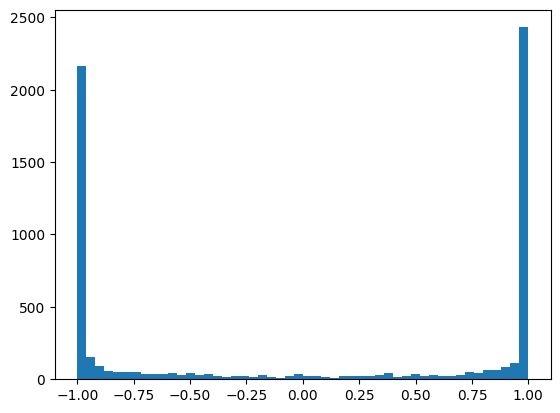

In [ ]:
# we see most common values are '-1's and '1's;
# this is linked to 'hpreact' whose range is -20 to 20;
# so makes sense more large input values tanh will be '-1' to '1'

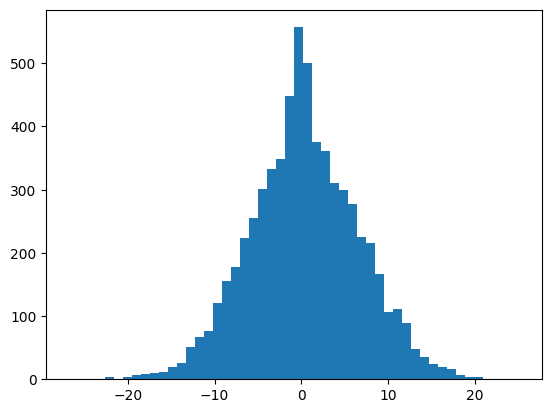

In [ ]:
# this is a boolen plot; where white is 'True', Black is 'False'
# y vs x --> number of example(in minibatch) vs number of neurons
# we see alot of the plot is white meaning alot of abs(values) are greater than 0.99.
# meaning alot of outputs from 'tanh'->out.data is in the flat tail region of its functional curve.
# thus alot of backward gradient 'out.grad' will get destroyed; and self.grad would not change much
# because out.data is basically kills the gradient by not impacting the loss coming back to it

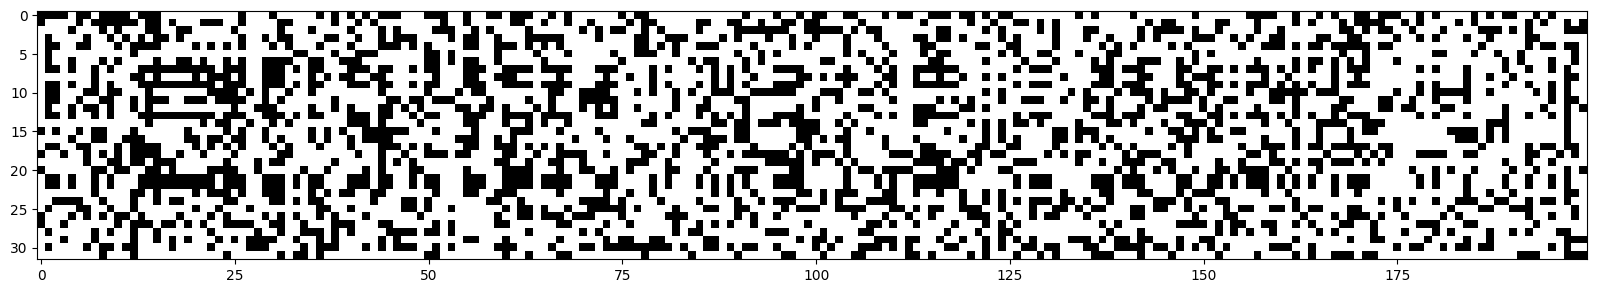

If one column (all 32 examples) here is completely white that indicates a dead neuron; which means after training, this neuron has learned nothing. So when new examples are passed through this neuron will only output 1 or -1 (white values).

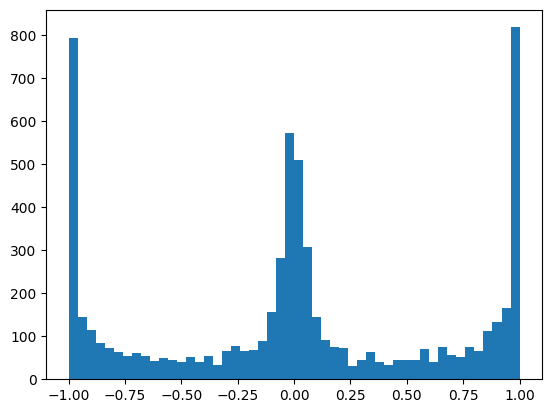

In [ ]:
# @title ######After fixing initiazation to fix saturated tanh outputs
plt.hist(h.view(-1).tolist(), 50);

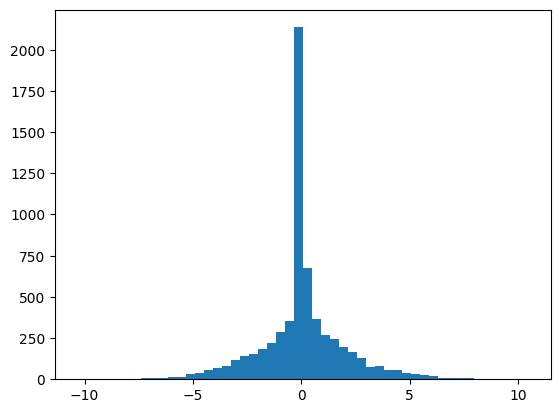

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

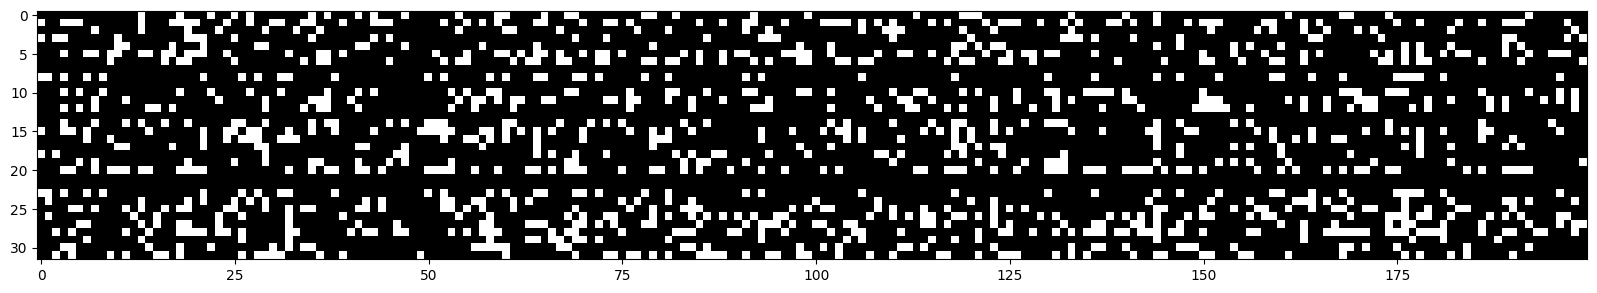

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

In [ ]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [ ]:
# -------------------------------------- S U M M E R Y & C O D E ---------------------------------------

In [ ]:
# @title #####Initialization
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #  gain for linear layer /fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar  = x.var(0, keepdim=True, unbiased=True) # batch variance
    else:
      xmean = self.running_mean
      xvar  = self.running_var

    xhat = (x - xmean)/torch.sqrt(xvar+self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var  = (1-self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

vocab_size = 27
block_size = 3
n_embd = 10 # the dimensionality of the character embedding vector
n_hidden = 100 # the number of neuron in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),       generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]
# layers = [
#     Linear(n_embd * block_size, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():

  ## last layer: make less confident (without batchnorm)
  #layers[-1].weight *= 0.1 # this was done at initialization of W2

  # last layer: make less confident (with batch norm)
  layers[-1].gamma *= 0.1 # this was done at initialization of W2

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # gain for layer feeding into Tanh -->((5/3)/fan_in**0.5) ; already added /fan_in**0.5 to linear layer

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47551


In [ ]:
# @title #####Training
# same optimizers as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update:data ratio

for i in range(max_steps):

  # mini-batch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

  with torch.no_grad(): # keeping track of update:data ratio
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000: # let it run for 1000 iter then break
    break # AFTER_DEBUG: remove this to run full 200000 optimization steps

      0/ 200000: 3.2870


Layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
Layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
Layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
Layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
Layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'Activation distribution for gain at every Linear layer = 5/3 AND WITH BATCHNORM1D')

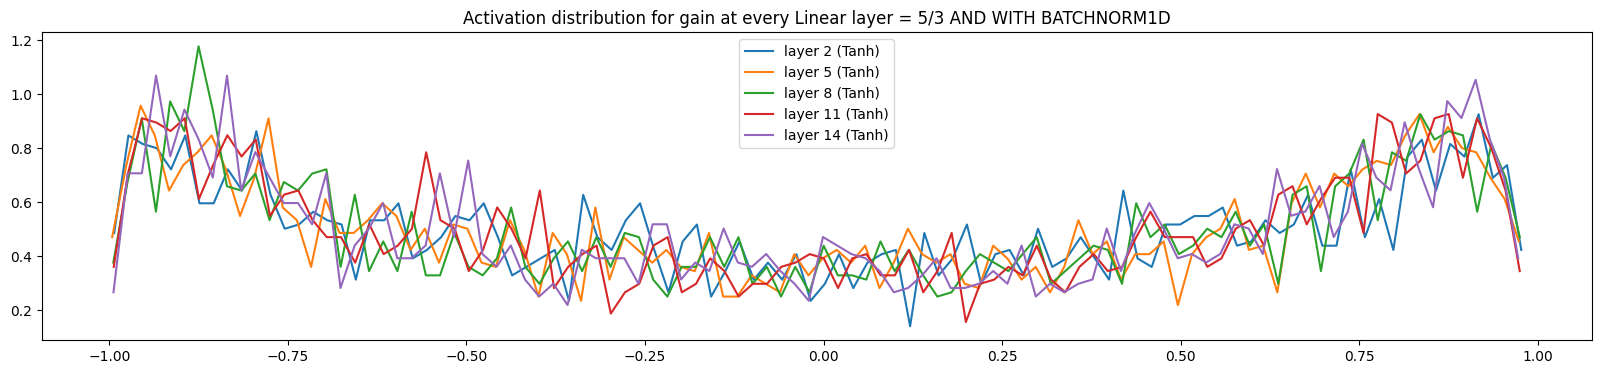

In [ ]:
# @title ######Visualize histograms of outputs (only for Tanh layers here)
# only visualizing Tanh outputs because they have a finite range (-1,1)

plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer because output layer is softmax not tanh
  if isinstance(layer, Tanh):
    t = layer.out
    print("Layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100 ))
    ## (t.abs() > 0.97).float().mean()*100 --> absolute values of output of tanh, that are greater than 0.97||
    ## output range of tanh(-1,1)|| to check how much of tanh ouput is saturated at its tails ends
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Activation distribution for gain at every Linear layer = 5/3 AND WITH BATCHNORM1D")

Layer 2 (      Tanh): mean -0.000000, std 3.682961e-03
Layer 5 (      Tanh): mean -0.000000, std 3.262612e-03
Layer 8 (      Tanh): mean +0.000000, std 2.973734e-03
Layer 11 (      Tanh): mean +0.000000, std 2.741114e-03
Layer 14 (      Tanh): mean +0.000000, std 2.584295e-03


Text(0.5, 1.0, 'Gradient distribution for at every linear layer gain=5/3 AND WITH BATCHNORM1D')

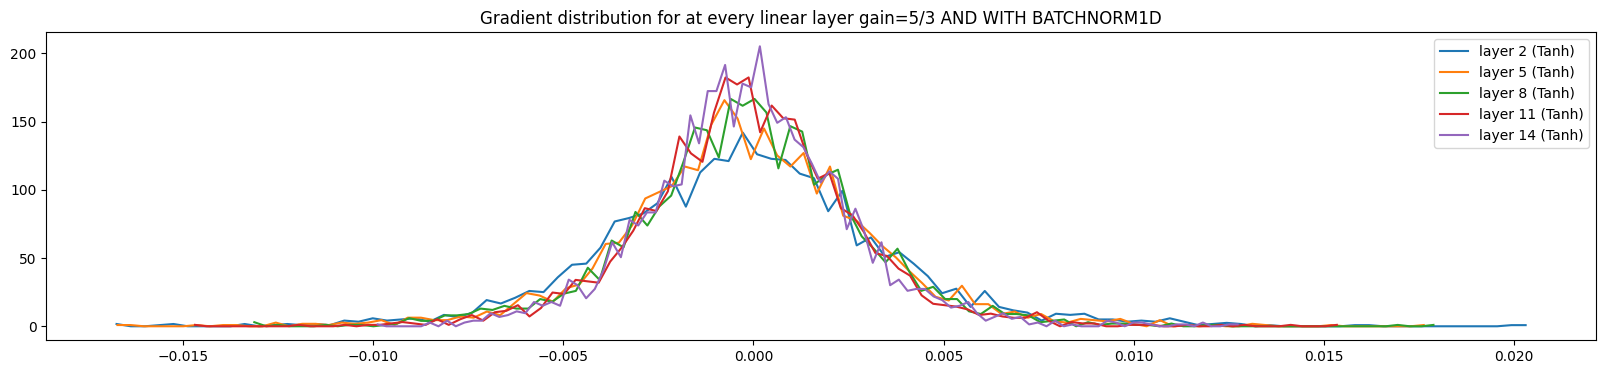

In [ ]:
# @title ######Visualize histograms of gradients (only for Tanh layers here)

plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('Layer %d (%10s): mean %+f, std %e' %(i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient distribution for at every linear layer gain=5/3 AND WITH BATCHNORM1D')

Weight   (27, 10) | mean +0.000000 | std 1.019890e-02 | grad:data ratio 1.018851e-02
Weight  (30, 100) | mean +0.000092 | std 8.238448e-03 | grad:data ratio 2.635845e-02
Weight (100, 100) | mean +0.000031 | std 7.318127e-03 | grad:data ratio 4.377153e-02
Weight (100, 100) | mean -0.000019 | std 6.662029e-03 | grad:data ratio 3.949899e-02
Weight (100, 100) | mean -0.000019 | std 5.821521e-03 | grad:data ratio 3.468164e-02
Weight (100, 100) | mean +0.000053 | std 5.445303e-03 | grad:data ratio 3.243371e-02
Weight  (100, 27) | mean -0.000165 | std 1.046846e-02 | grad:data ratio 6.281275e-02


Text(0.5, 1.0, 'Weights gradient distribution AND WITH BATCHNORM1D')

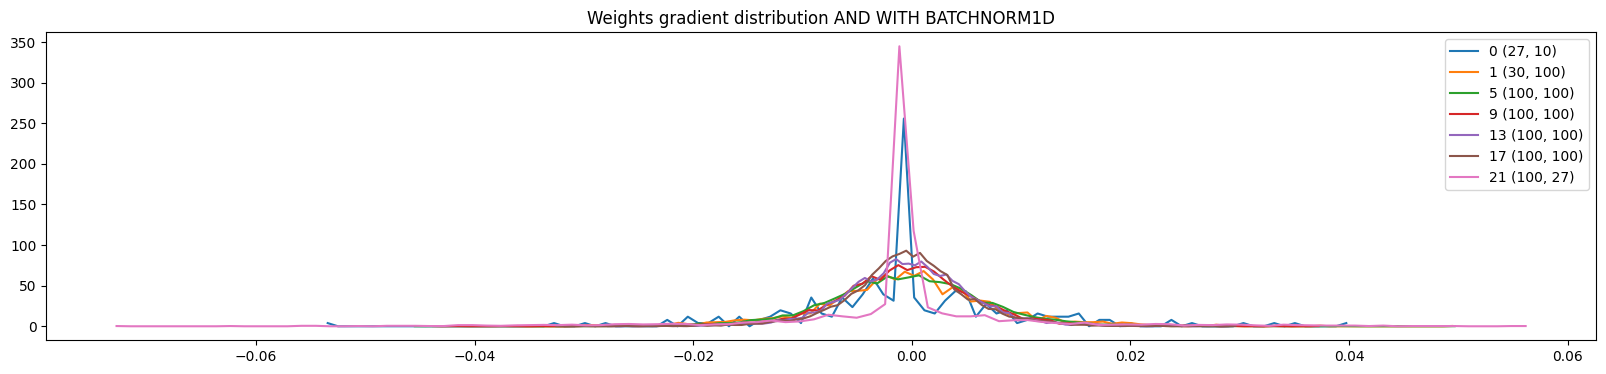

In [ ]:
# @title ######Visualize histograms of gradients (only for parameters here) (grad:data ratio)

plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # only looking at 2 dimensional parameters i.e weights, biases; skipping all batch norm 1-D parameters
    print('Weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights gradient distribution AND WITH BATCHNORM1D')

In [ ]:
'''
grad:data ratio is good to look at because for update we do p.data += -lr * p.grad || so if grad is too big compared to data the changes to p.data will be very fast.
std of the parameters is also important to see; they should all have roughly the same std throgh-out which is the case here (except for the last layer, std for last layer is 10 times other layers)
This last layer problem it due to how the layers are arranged, but it fixes itself somewhat if we run for long enough

But instead of grad:data ratio, it is better to look at update:data ratio

'''
 #

Text(0.5, 1.0, 'update:data ratio for learning rate 0.1 AND WITH BATCHNORM1D')

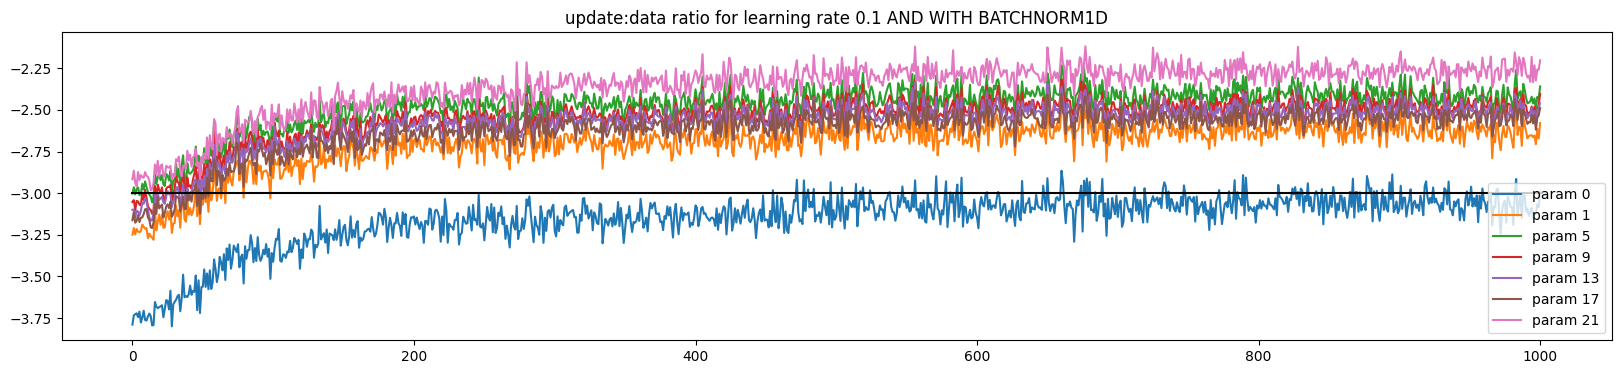

In [ ]:
# @title ######Visualize  (updata:data ratio)

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title("update:data ratio for learning rate 0.1 AND WITH BATCHNORM1D")
# y vs x --> update:data vs iteration

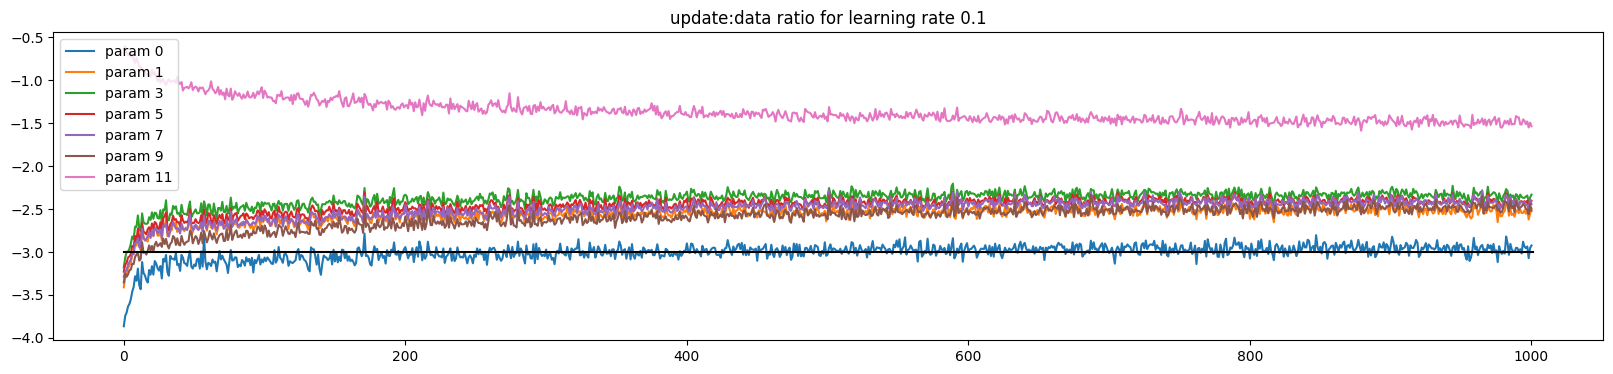

Watch Karpathy makemore video 3; from 1:46:00 again

In [ ]:
'''
For low learning rate we see these updates to data ratio is very very slow (compare it with the black ~1e-3 line)
Also go see how we made the last layer less confident by multiplying last layers weights with 0.1; this corresponds to the pink line (last layer) not being the same as other lines.
But this will converge eventually when NN learns.

So what we see from these 2 plots are, how the data updates over time/iterations i.e. update to data ratio.
A refereance line (black ~1e-3) is drawn; if lines are below this black line then the update is slow. All lines should be around the referance line
'''

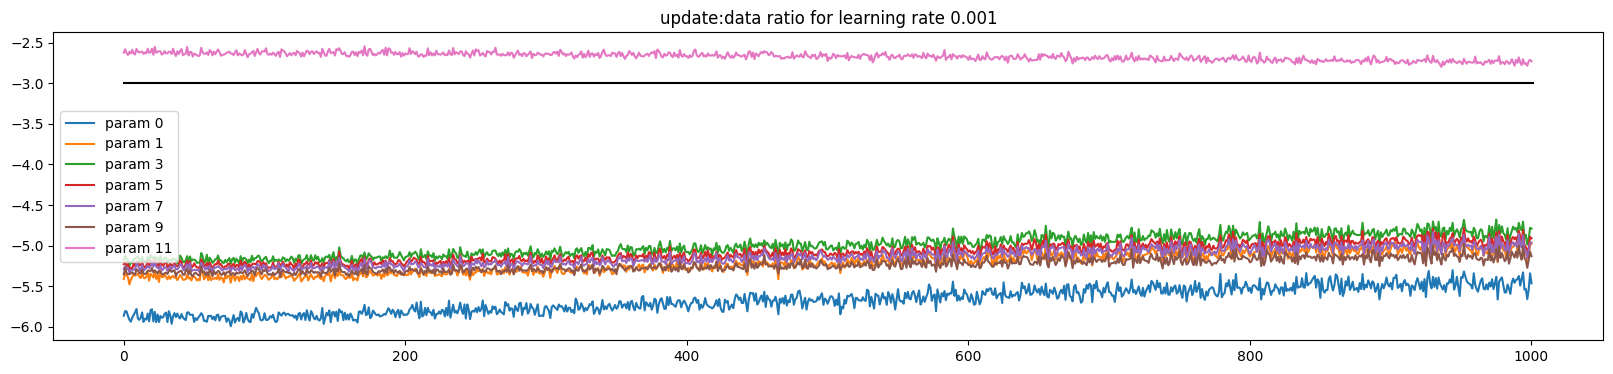

Effects of changing gains, layer defination (no Tanh) etc. by plotting a graph of their statistics for forward pass(activations) and backward pass (gradients)

In [ ]:
#-------------------------------------------ACTIVATION DISTRIBUTION------------------------------------------------------------------------------------------

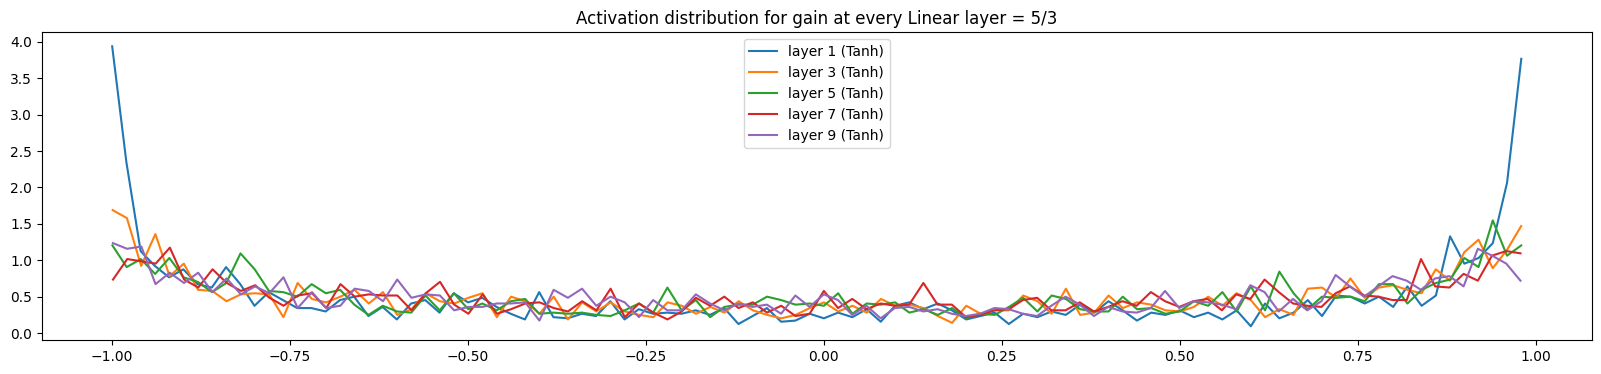

In [ ]:
'''
This is the effect of tanh as a squashing function. We have talked before how if input to tanh is high/low enough, tanh will give outputs from its tail ends (-1,1).
In this neural network we have Linear layers with intermediete Tanh layers. We have initialized the weights of Linear layers as per kaiming, and this would have been
enough to conserve a normal distribution (mean=0,std=1); if not for the Tanh layers. So some gain is necessary at every input to the tanh(linear layer weights here).
For tanh its 5/3; this will fight the squashing effect of tanh on the normal distribution by giving values a boost/gain.

Squashing effect--> see how for gain=1 the layers are getting squashed togather towards the middle, compared to when gain=5/3.
'''
#

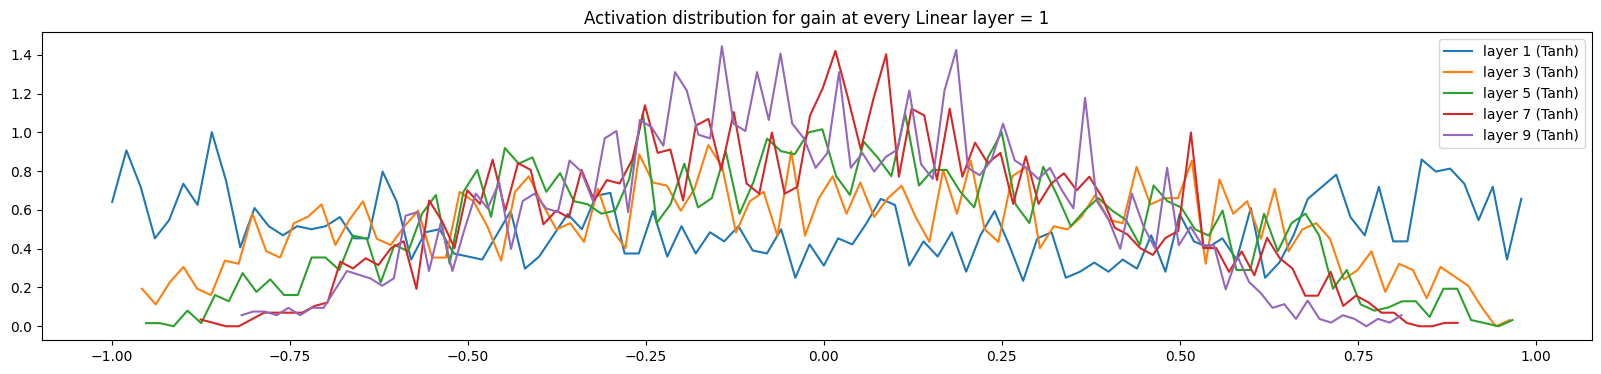

In [ ]:
'''
For too much gain(=3) the activations/outputs of tanh gets saturated at the ends(-1,1) for every layer.
For no gain(=1) the activations/outputs of tanh don't get saturated, rather gets squashed togather and doesn't conserve the normal distribution
For gain(=5/3) activations/outputs of tanh conserve the normal distribution reasonbly and all the layer outputs don't end up at tail(-1,1)ends.
'''
#

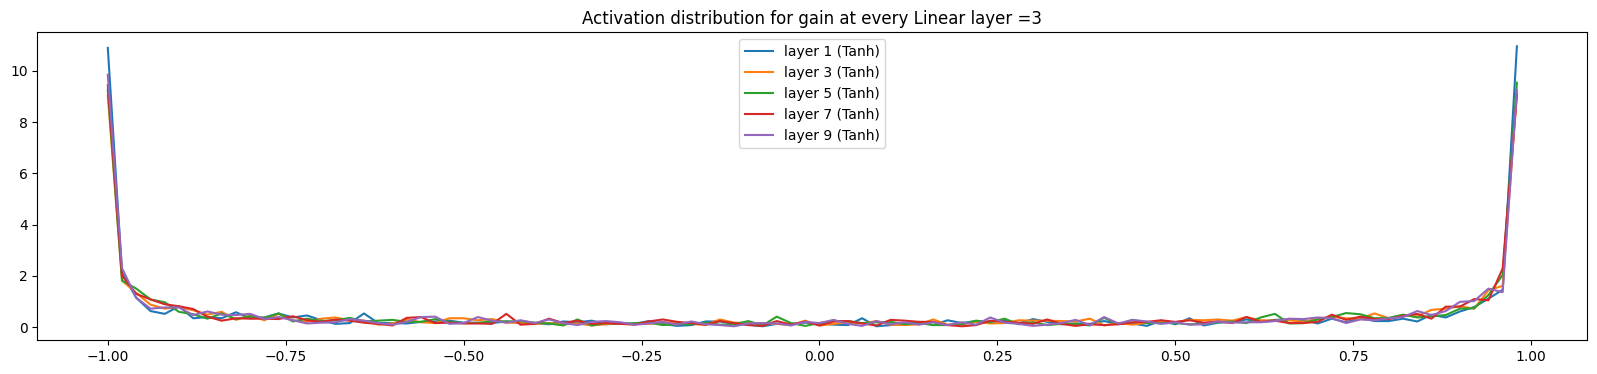

In [ ]:
#-----------------------------------------------GRADIENT DISTRIBUTION--------------------------------------------------------------------------------------

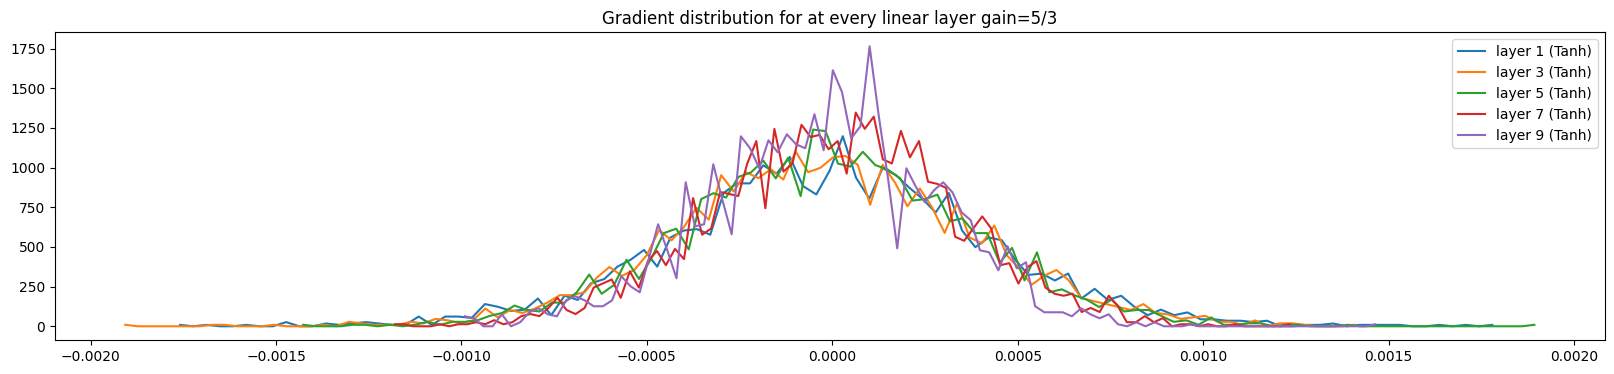

In [ ]:
'''
For small gain(around 1 or 0.5), we see tanh output gradients are assymetric. Gradient are changing layer to layer. Below we see how the gradients are spread accross layers.
Layer 1 has gradient values condensed near 1, whereas subsequent layers have more spaced out gradients.
We also see above for those small gains, the activations(output of tanh) were getting squashed togather

For bigger gain(around 3), the inverse thing happens and gradients are also assymetric. Layer 8 have more condensed gradient values followed by preceding layer serially.
in this case the activations(outputs of tanh) were saturated (near -1,1) at every layer. See picture above

For optimum gain=5/3; we see for every layer the gradients are around the same values (with some jitter/noise)
in this case, activations didn't saturate at tail ends(-1,1) and didn't get squashed togather (so maintain normal distribution)
'''
#

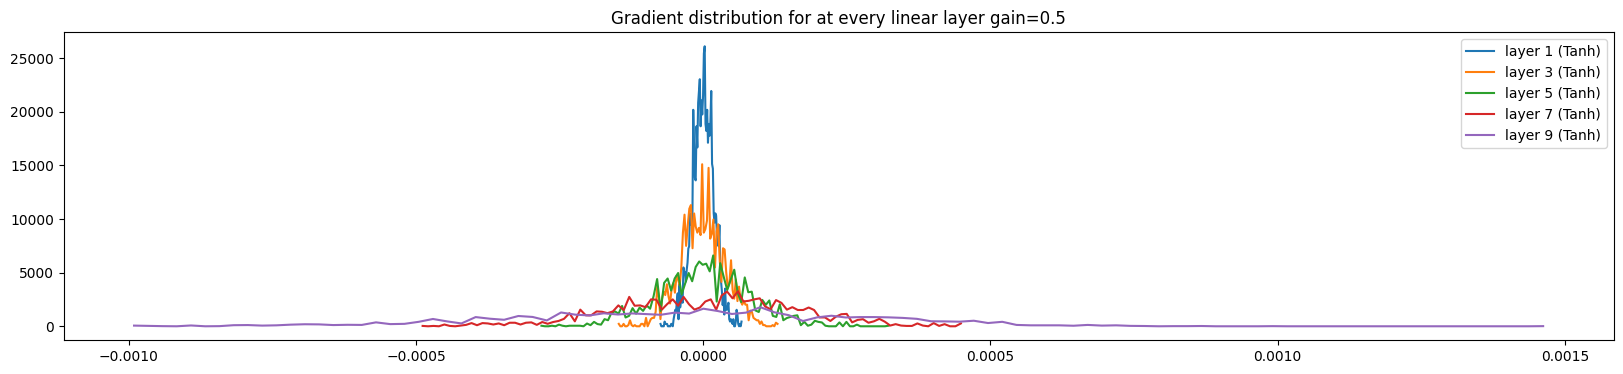

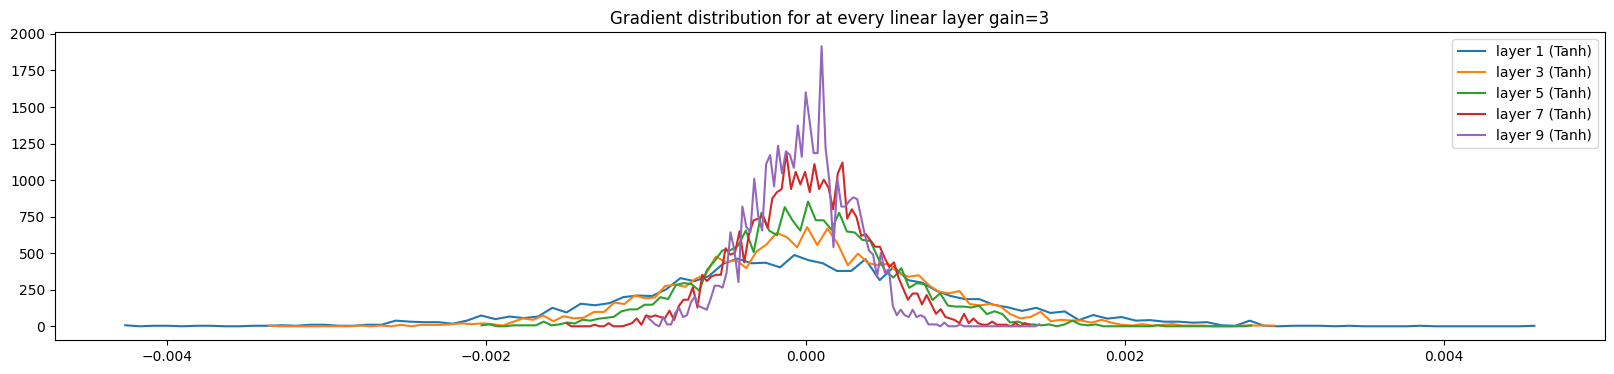

In [ ]:
#--------------------------- All linear layers no Tanh layer and gain is 5/3 which is large (linear layer gain is = 1)----------------------------

In [ ]:
'''
Removed all the Tanh layers so the NN is just a sandwich of linear layers. For linear layers the gain=1, but we kept gain=5/3. This created the assymmetry is the graphs.
For activations, Layer 1 started centered around '0' and layer by layer this distribution became more diffuse/spaced out. And assymetry between layers is present
For gradients, Layer 4 started around '0' and layer by layer this distribution became more diffuse. Also assymmetric.

We don't want to be in this region (especially in deep NN), we don't want the distributions to be assymetric.
We want roughly normal distributions all accross the layers (atleast at init), and layers activations & gradients trend should be symmetric
'''
#

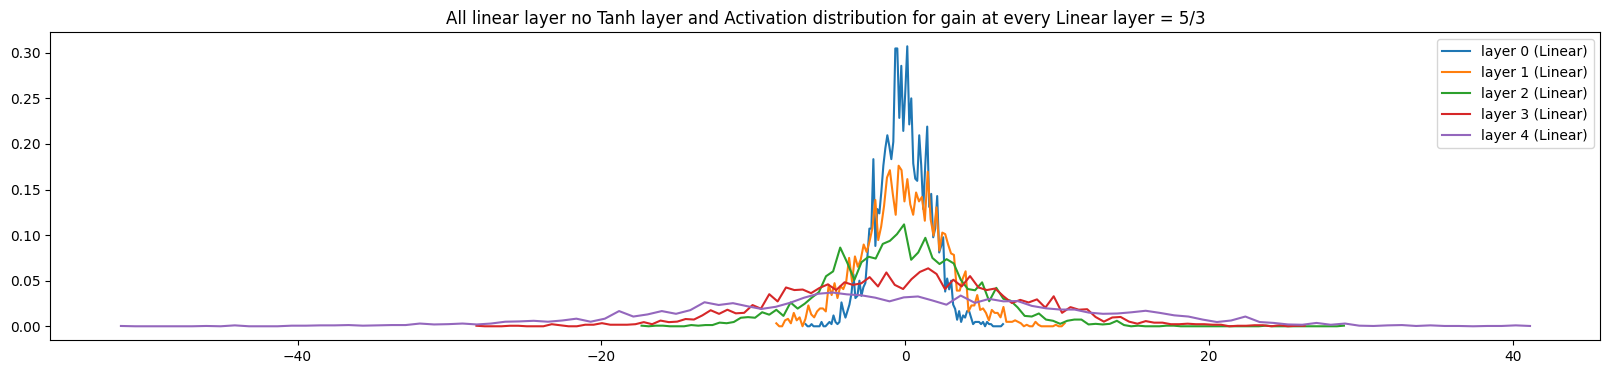

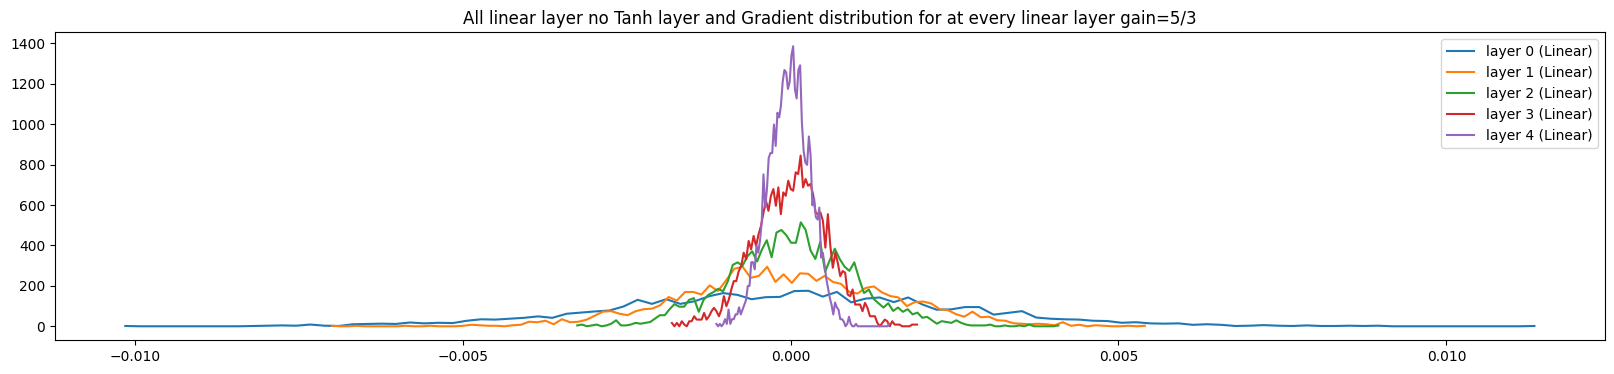

In [ ]:
# ----------ALl linear layers no Tanh layer and gain is .5 which is small (linear layer gain is = 1)---------

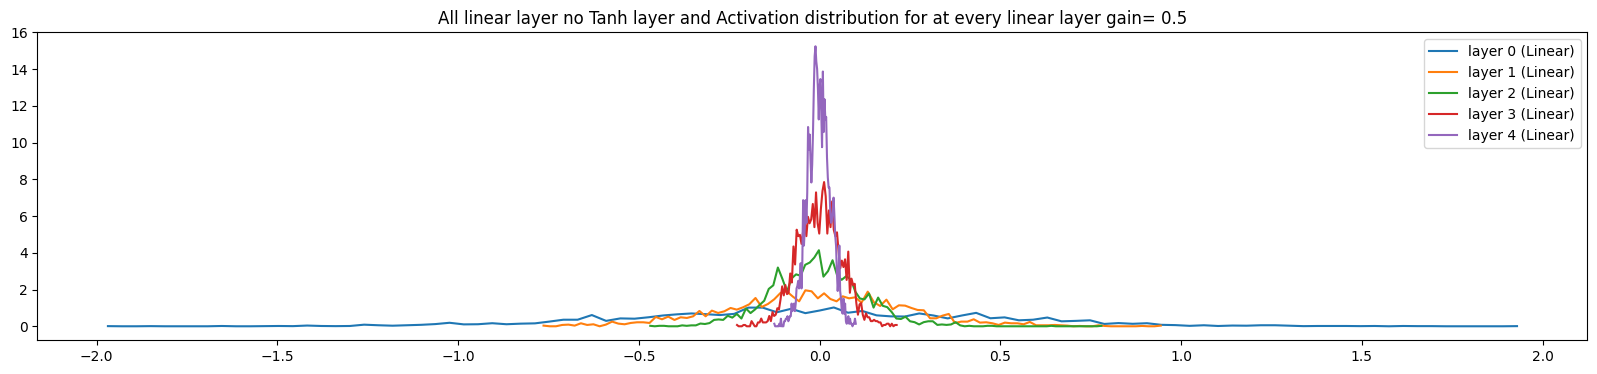

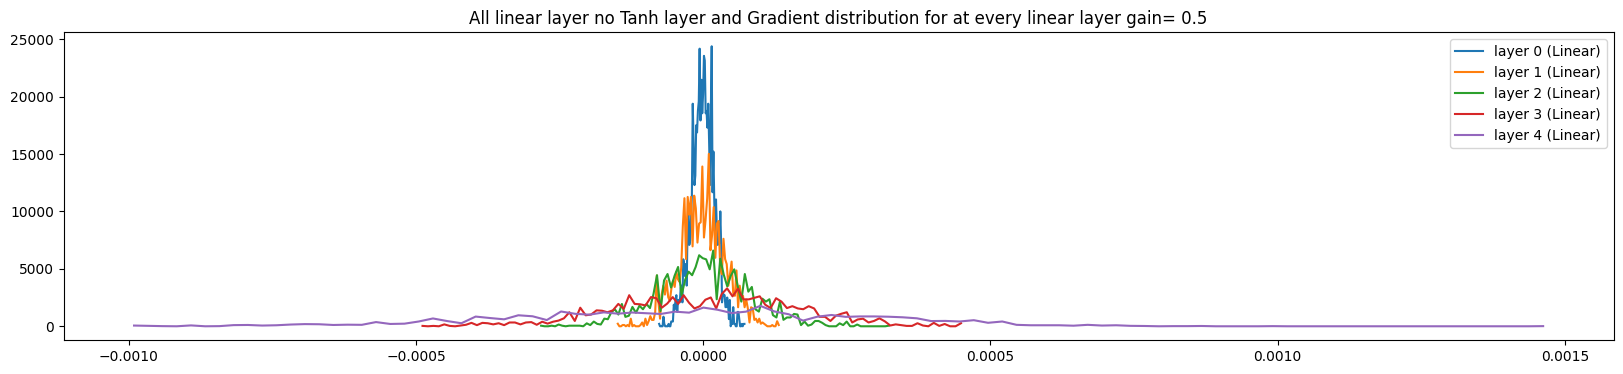

In [ ]:
# ----------------------ALl linear layers no Tanh layer and gain is 1 ---------------------
# we see the statistics for layers are well behaved

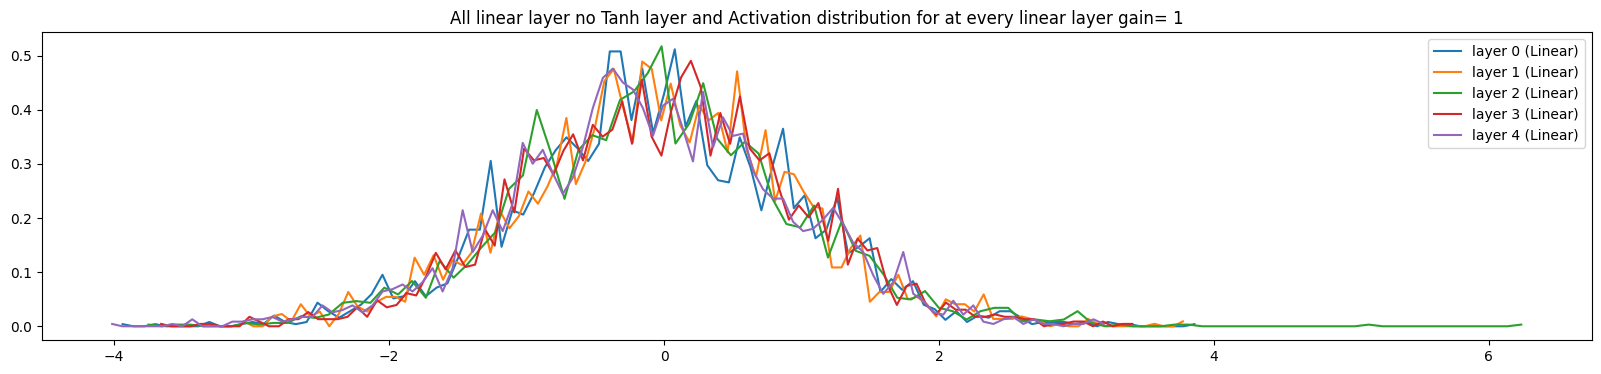

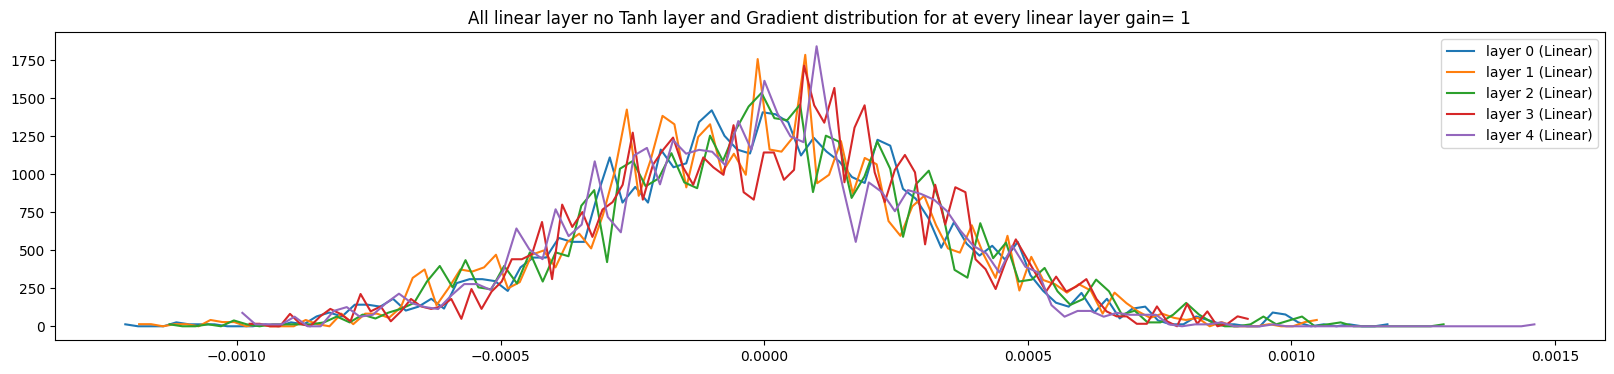